In [16]:
import sys
sys.path
sys.path.append("../../quMCMC") 
import os
import pickle


In [2]:
import qumcmc
from qumcmc.classical_mcmc_routines import *
## import essential modules 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines import quantum_enhanced_mcmc # Manuel's code
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from qumcmc.prob_dist import DiscreteProbabilityDistribution

### Load the BAS dataset

In [3]:
gridsize=3

bas= bas_dataset(grid_size=gridsize)
bas.dataset.sort()

     MODEL : ising model BAS 9X9 bars + stripes |  beta : 1.5
Num Most Probable States : 12
Entropy : 3.5849625001146053
---------------------------------------------


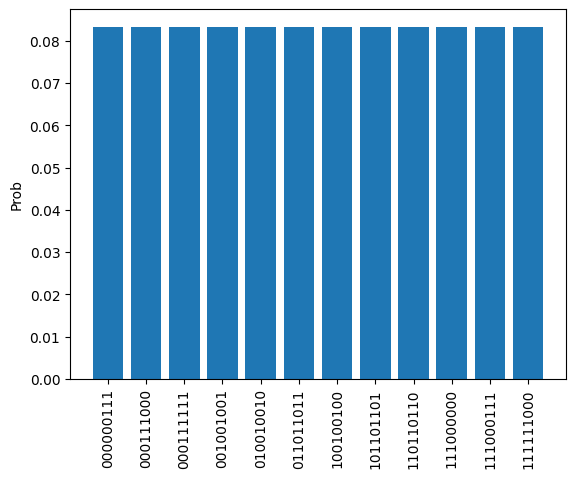

In [4]:
# consider only the bars dataset and create the weight matrix for them and create the ising model
wt= hebbing_learning(bas.bas_dict["bars"]+ bas.bas_dict["stripes"])## added 2 datapoints from stripes dataset into it
n_spins=gridsize*gridsize
shape_of_J=(n_spins,n_spins)
J=-1*wt
h=np.zeros(n_spins)
model=IsingEnergyFunction(J,h,name=f'ising model BAS {n_spins}X{n_spins} bars + stripes')

# model.model_summary()
beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd_2= DiscreteProbabilityDistribution(exact_sampled_model.boltzmann_pd)
exact_sampled_model.sampling_summary()


In [5]:
### let's check if the new code is even working as desired or not
from qumcmc.mixers import GenericMixer, CustomMixer, CoherentMixerSum, IncoherentMixerSum

### Now run 10 different chains for each case and save the data

In [6]:
num_chains=10
steps =10000 # 30000
gamma_range=(0.4,0.6)

initial_state="111000111"

In [25]:
### Creating the mixers we need

generic_mixer = GenericMixer.OneBodyMixer(n_spins)
custom_mixer_stripes = CustomMixer(n_spins,[[0,3,6],[1,4,7],[2,5,8]])
custom_mixer_bars =  CustomMixer(n_spins,[[0, 1, 2], [3, 4, 5], [6, 7, 8]] )

custom_mixer_BAS = CustomMixer(n_spins,[[0, 1, 2], [3, 4, 5], [6, 7, 8], [0,3,6] , [1,4,7] , [2,5,8]] )

coherent_mixer_only_bars = CoherentMixerSum([generic_mixer, custom_mixer_bars], 
                                            weights=[0.75, 0.25])
coherent_mixer_with_BAS_info = CoherentMixerSum([generic_mixer, custom_mixer_bars, custom_mixer_stripes],
                                                weights=[0.7,0.15,0.15])

coherent_mixer_BAS = lambda p : CoherentMixerSum([generic_mixer, custom_mixer_BAS], weights= [1-p, p] )
incoherent_mixer_BAS = lambda p : IncoherentMixerSum([generic_mixer, custom_mixer_BAS], probabilities= [1-p, p] )



incoherent_mixer_only_bars = IncoherentMixerSum([generic_mixer, custom_mixer_bars],
                                                probabilities=[0.75, 0.25])
incoherent_mixer_with_BAS_info = IncoherentMixerSum([generic_mixer, custom_mixer_bars, 
                                                    custom_mixer_stripes],
                                                probabilities=[0.7,0.15,0.15])

### Trying to standarise the problem for the case of mixture of mixers

#### coherent mixer

In [31]:
# Get the current working directory (PWD)
pwd = os.getcwd()
# Define the new folder name
new_folder_name = "BAS-coherent-mixers"
# Create the full path for the new folder
results_folder_location = os.path.join(pwd, new_folder_name)
print(results_folder_location)


num_chains=10
steps=20*1000 # 30000
initial_state="111000111"
gamma=0.5

## mixer customisation ratio : mcr 
mcr_range= np.linspace(0.01, 0.50, 6)

/home/rpal/Documents/QBMS/quMCMC/final_results_notebooks/BAS-coherent-mixers


In [32]:
for mcr in mcr_range:
    print('mcr: ', str(mcr))
    bas_std=[]
    for i in range(0, num_chains):  
        mcmc_std = quantum_enhanced_mcmc(
                                            n_hops=steps,
                                            model=model,
                                            mixer=coherent_mixer_BAS(mcr),
                                            gamma = gamma,#(0.9,0.45), # to standardise the problem
                                            initial_state=initial_state,
                                            temperature=1/beta, 
                                            verbose=True
                                        )
        bas_std.append(mcmc_std)



    ### save the list
    save_files_at = results_folder_location + "/mcr=" + str(mcr) + ".pkl" 
    with open(save_files_at, 'wb') as f:
        pickle.dump(bas_std, f)

mcr:  0.01
starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:14<00:00, 267.91it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:07<00:00, 294.33it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:09<00:00, 285.96it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:08<00:00, 292.57it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:12<00:00, 277.66it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:09<00:00, 286.46it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:08<00:00, 291.17it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:20<00:00, 247.21it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:09<00:00, 289.53it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:08<00:00, 292.29it/s]


mcr:  0.108
starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:06<00:00, 300.81it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:05<00:00, 303.30it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:06<00:00, 299.67it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:07<00:00, 295.28it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:06<00:00, 301.26it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:07<00:00, 296.41it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:09<00:00, 285.84it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:07<00:00, 298.20it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:13<00:00, 272.42it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:06<00:00, 300.28it/s]


mcr:  0.20600000000000002
starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:02<00:00, 319.38it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:09<00:00, 287.46it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:10<00:00, 284.65it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:12<00:00, 276.84it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:08<00:00, 291.47it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:11<00:00, 281.53it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:12<00:00, 275.09it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [01:20<00:00, 248.94it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:53<00:00, 373.68it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 389.09it/s]


mcr:  0.30400000000000005
starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:52<00:00, 382.90it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 388.34it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:52<00:00, 380.35it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 391.25it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 388.07it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:50<00:00, 392.42it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 389.43it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:52<00:00, 382.88it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 387.53it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 391.28it/s]


mcr:  0.402
starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 386.27it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 389.80it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 391.05it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:50<00:00, 394.57it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:51<00:00, 385.31it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:53<00:00, 376.10it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:52<00:00, 381.16it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:52<00:00, 378.50it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:53<00:00, 377.15it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:52<00:00, 378.50it/s]


mcr:  0.5
starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [00:52<00:00, 378.74it/s]


starting with:  111000111 with energy: -48.0


runnning quantum MCMC steps . ..:  46%|████▋     | 9285/20000 [00:24<00:31, 339.02it/s]

#### incoherent mixer 

In [ ]:
# Get the current working directory (PWD)
pwd = os.getcwd()
# Define the new folder name
new_folder_name = "BAS-incoherent-mixers"
# Create the full path for the new folder
results_folder_location = os.path.join(pwd, new_folder_name)
print(results_folder_location)


num_chains=10
steps=20*1000 # 30000
initial_state="111000111"
gamma=0.5

## mixer customisation ratio : mcr 
mcr_range= np.linspace(0.01, 0.50, 6)

In [ ]:
for mcr in mcr_range:
    print('mcr: ', str(mcr))
    bas_std=[]
    for i in range(0, num_chains):  
        mcmc_std = quantum_enhanced_mcmc(
                                            n_hops=steps,
                                            model=model,
                                            mixer=incoherent_mixer_BAS(mcr),
                                            gamma = gamma,#(0.9,0.45), # to standardise the problem
                                            initial_state=initial_state,
                                            temperature=1/beta, 
                                            verbose=True
                                        )
        bas_std.append(mcmc_std)



    ### save the list
    save_files_at = results_folder_location + "/mcr=" + str(mcr) + ".pkl" 
    with open(save_files_at, 'wb') as f:
        pickle.dump(bas_std, f)

## #

## commit 